# Avoiding catastrophic interference with dreams generated by Monte Carlo Langevin dynamics

The test is performed on MNIST data.

In this version we use
- Predictor-corrector algorithm for the Langevin dynamic
- Only samples with better output activity are used for training

In [1]:
import os
# Disable GPU in a case of kernel freezing
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from progressbar import ProgressBar  # pip install progressbar33
from keras import optimizers
from keras.callbacks import EarlyStopping
from scipy.special import expit

Using TensorFlow backend.


In [3]:
# def inverse_permutation(perm): # inverse permutation
#     inverse = [0] * len(perm)
#     for i, p in enumerate(perm):
#         inverse[p] = i
#     return inverse

In [4]:
# Parameters of basis training
num_epoch = 20
num_neur = 400 # number of neurons in hidden layers
num_class = 10
img_line = 784
bsize = 32 # batch size
l2 = 1e-4 # L2 regularization

# Parameters of generative process
llr = 0.1 # learning rate for Largevin sampling
ll2 = 0.01 # prior weights distribution
burnin = 500 # amount of burn-in iterations
high_activity_part = 0.5 # the part of dreams to keep

nb_epochs = 100000 # number of samples of certain class to generate
demix = 10 # number of samples to skip to prevent mixing
# note that number of saved samples is nb_epochs//demix

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
# Preprocess MNIST data
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, 10)
Y_test = utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

## Training network  on data A

In [7]:
if os.path.isfile('weights_a.h5'): # if network was trained before
    model.load_weights("weights_a.h5") # load weights
    score_a = np.load('score_a.npy') # load training history for data A
    order_a = np.loadtxt('order_a.txt', dtype=int) # load permutation order of data A
    # Restore permitted data A
    tr_a = X_train[:,order_a]
    ts_a = X_test[:,order_a]
else: # train network from begining if not trained before
    order_a = np.random.permutation(img_line)
    np.savetxt('order_a.txt', order_a, fmt='%d') # save permutation order
    tr_a = X_train[:,order_a]
    ts_a = X_test[:,order_a]

    score_a = np.zeros((num_epoch,2))
    history = model.fit(tr_a, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(ts_a,Y_test), verbose=0)
    model.save_weights('weights_a.h5') # save weights for further use
    score_a[:,0] = range(num_epoch)
    score_a[:,1] = history.history['val_acc']
    np.save('score_a', score_a)

    plt.plot(score_a[:,0],score_a[:,1])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Perform posterior sampling with Langevin dynamics

Construct network for posterior sampling

In [8]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False

In [9]:
x_in = np.array([[1]]) # the only input for the new network

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Sample posterior for every active output unit.

In [10]:
dreams_a = np.empty(shape=[0, img_line])
nd = 1 # noise reduction factor 
predictor_corrector = True

for neuron in range(num_class): # output neuron for activation maximization
    y_out = np.zeros((1,10))
    y_out[0][neuron] = 1 # establish target values
    weights = 0.1*np.random.normal(0,1,(1,img_line))
    model_dream.layers[0].set_weights([weights]) # initialize random weights
    for i in range(burnin): # burn-in loop
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
        weights = model_dream.layers[0].get_weights()[0] # get input weights
        weights += np.sqrt(2*llr/nd)*np.random.normal(0,1,weights.shape) # add Gaussian noise
        model_dream.layers[0].set_weights([weights])
    print('Generating samples for unit #%d...' % (neuron))
    dreams1 = np.zeros((nb_epochs//demix,img_line))
    pbar = ProgressBar(maxval=nb_epochs).start()
    for i in range(nb_epochs): # start of dreams generation
        weights0 = model_dream.layers[0].get_weights()[0]
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
        weights = model_dream.layers[0].get_weights()[0] # get input weights
        xi = np.sqrt(2*llr/nd)*np.random.normal(0,1,weights.shape) # Gaussian noise
        weights += xi # one step of random walk
        if predictor_corrector:
            model_dream.layers[0].set_weights([weights])
            model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
            weights = model_dream.layers[0].get_weights()[0]
            weights = (weights0+weights+xi)/2
        model_dream.layers[0].set_weights([weights])
        if i%demix==0: # keep demixed sample
            dreams1[i//demix,:] = expit(weights)[0]
        pbar.update(i+1)
    pbar.finish()
    np.save('Langevin_dream_a_#'+str(neuron), dreams1)
    dreams_a = np.append(dreams_a, dreams1, axis=0)

Generating samples for unit #0...


100% |########################################################################|


Generating samples for unit #1...


100% |########################################################################|


Generating samples for unit #2...


100% |########################################################################|


Generating samples for unit #3...


100% |########################################################################|


Generating samples for unit #4...


100% |########################################################################|


Generating samples for unit #5...


100% |########################################################################|


Generating samples for unit #6...


100% |########################################################################|


Generating samples for unit #7...


100% |########################################################################|


Generating samples for unit #8...


100% |########################################################################|


Generating samples for unit #9...


100% |########################################################################|


## Training network on data B

Load recorded dreams (artificial training samples); choose the dreams that produce high output activity

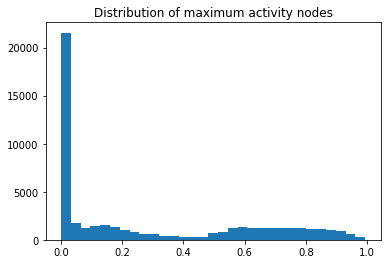

In [11]:
dreams_a = np.empty(shape=[0, img_line])
dreamY_max = np.empty(shape=[0, 1])
for neuron in range(num_class): 
    dreams1 = np.load('Langevin_dream_a_#'+str(neuron)+'.npy') # load dreams of certain class
    y1 = model.predict(dreams1) # calculate output activity produced by the dreams
    ind = np.argsort(y1[:,neuron])
    dreams1 = dreams1[ind,:] # dreams sorted according to activity of certain output neuron
    indmax = int(np.ma.size(dreams1,axis=0)*high_activity_part)
    dreams1 = dreams1[-indmax:,:] # leave only high-activity dreams
    dreams_a = np.append(dreams_a, dreams1, axis=0)
    dreamY_max = np.append(dreamY_max,model.predict(dreams1)[:,neuron])
    
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

In [12]:
# neuron = 9
# dreams1 = np.load('Langevin_dream_a_#'+str(neuron)+'.npy') # load dreams of certain class
# y1 = model.predict(dreams1)
# ind = np.argsort(y1[:,neuron])
# y1 = y1[ind,:] # dreams sorted according to activity of certain output neuron
# indmax = int(np.ma.size(dreams1,axis=0)*0.4)
# y1 = y1[-indmax:,:]
# print(y1[:,neuron])

Use data B together with dreams for training

In [13]:
dreamY_a = model.predict(dreams_a)

100% |########################################################################|


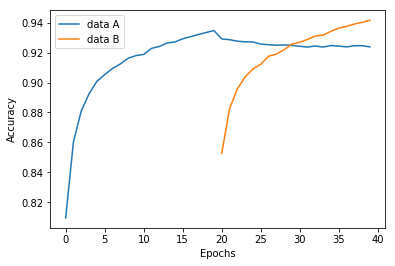

In [14]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
if os.path.isfile('Langevin_weights_ab.h5'): # if network was trained before
    model.load_weights("Langevin_weights_ab.h5") # load weights
    score_ab = np.load('Langevin_score_ab.npy') # load training history for data A and B
    order_b = np.loadtxt('Langevin_order_b.txt', dtype=int) # load permutation order of data B
    # Restore permutted data B
    tr_b = X_train[:,order_b]
    ts_b = X_test[:,order_b]
else: # train network from begining if not trained before
    # construct B data
    order_b = np.random.permutation(img_line)
    np.savetxt('Langevin_order_b.txt', order_b, fmt='%d') # save permutation order for data B
    tr_b = X_train[:,order_b]
    ts_b = X_test[:,order_b]

    tr_ab = np.concatenate((tr_b, dreams_a), axis=0) # add pseudodata to the training data
    Y_ab = np.concatenate((Y_train, dreamY_a), axis=0) # add pseudotargets to the targets
    # permute training samples for proper validation set
    order_all = np.random.permutation(tr_ab.shape[0])
    tr_ab = tr_ab[order_all,:]
    Y_ab = Y_ab[order_all,:]

    score_ab = np.zeros((num_epoch,3))
    pbar = ProgressBar(maxval=num_epoch).start()
    for epoch in range(num_epoch):
        model.fit(tr_ab, Y_ab, batch_size=bsize, epochs=1, verbose=0)
        score1 = model.evaluate(ts_a, Y_test, verbose=0)
        score2 = model.evaluate(ts_b, Y_test, verbose=0)
        score_ab[epoch,:] = [epoch+num_epoch,score1[1],score2[1]]
        pbar.update(epoch+1)
    pbar.finish()
    model.save_weights('Langevin_weights_ab.h5') # save weights for further use
    np.save('Langevin_score_ab', score_ab) # save the history of training

# plot the accuracy of training
plt.plot(np.hstack((score_a[:,0],score_ab[:,0])),np.hstack((score_a[:,1],score_ab[:,1])),label='data A')
plt.plot(score_ab[:,0],score_ab[:,2],label='data B')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Perform new posterior sampling

In [15]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Sample posterior for every active output unit

In [16]:
dreams_ab = np.empty(shape=[0, img_line])
nd = 1 # noise reduction factor 
predictor_corrector = True

for neuron in range(num_class): # output neuron for activation maximization
    y_out = np.zeros((1,10))
    y_out[0][neuron] = 1 # establish target values
    weights = 0.1*np.random.normal(0,1,(1,img_line))
    model_dream.layers[0].set_weights([weights]) # initialize random weights
    for i in range(burnin): # burn-in loop
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
        weights = model_dream.layers[0].get_weights()[0] # get input weights
        weights += np.sqrt(2*llr/nd)*np.random.normal(0,1,weights.shape) # add Gaussian noise
        model_dream.layers[0].set_weights([weights])
    print('Generating samples for unit #%d...' % (neuron))
    dreams1 = np.zeros((nb_epochs//demix,img_line))
    pbar = ProgressBar(maxval=nb_epochs).start()
    for i in range(nb_epochs): # start of dreams generation
        weights0 = model_dream.layers[0].get_weights()[0]
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
        weights = model_dream.layers[0].get_weights()[0] # get input weights
        xi = np.sqrt(2*llr/nd)*np.random.normal(0,1,weights.shape) # Gaussian noise
        weights += xi # one step of random walk
        if predictor_corrector:
            model_dream.layers[0].set_weights([weights])
            model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
            weights = model_dream.layers[0].get_weights()[0]
            weights = (weights0+weights+xi)/2
        model_dream.layers[0].set_weights([weights])
        if i%demix==0: # keep demixed sample
            dreams1[i//demix,:] = expit(weights)[0]
        pbar.update(i+1)
    pbar.finish()
    np.save('Langevin_dream_ab_#'+str(neuron), dreams1)
    
    dreams_ab = np.append(dreams_ab, dreams1, axis=0)

Generating samples for unit #0...


100% |########################################################################|


Generating samples for unit #1...


100% |########################################################################|


Generating samples for unit #2...


100% |########################################################################|


Generating samples for unit #3...


100% |########################################################################|


Generating samples for unit #4...


100% |########################################################################|


Generating samples for unit #5...


100% |########################################################################|


Generating samples for unit #6...


100% |########################################################################|


Generating samples for unit #7...


100% |########################################################################|


Generating samples for unit #8...


100% |########################################################################|


Generating samples for unit #9...


100% |########################################################################|


## Training network on data C

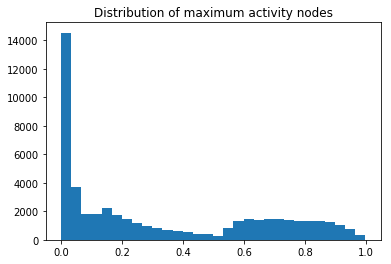

In [17]:
# load recorded dreams from disk
dreams_ab = np.empty(shape=[0, img_line])
dreamY_max = np.empty(shape=[0, 1])
for neuron in range(num_class): 
    dreams1 = np.load('Langevin_dream_ab_#'+str(neuron)+'.npy') # load dreams of certain class
    y1 = model.predict(dreams1)
    ind = np.argsort(y1[:,neuron])
    dreams1 = dreams1[ind,:] # dreams sorted according to activity of certain output neuron
    indmax = int(np.ma.size(dreams1,axis=0)*high_activity_part)
    dreams1 = dreams1[-indmax:,:] 
    dreams_ab = np.append(dreams_ab, dreams1, axis=0)
    dreamY_max = np.append(dreamY_max,model.predict(dreams1)[:,neuron])
    
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()    

In [18]:
dreamY_ab = model.predict(dreams_ab)

100% |########################################################################|


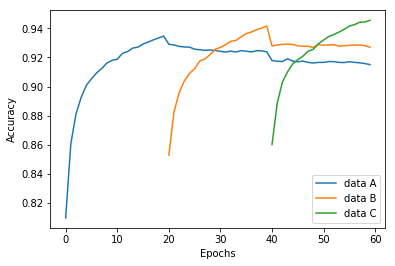

In [19]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True

# create dataset C
order_c = np.random.permutation(img_line)
tr_c = X_train[:,order_c]
ts_c = X_test[:,order_c]

# add pseudodata to the training data
tr_abc = np.concatenate((tr_c, dreams_ab), axis=0) 
Y_abc = np.concatenate((Y_train, dreamY_ab), axis=0)
# permute training samples for proper validation set
order_all = np.random.permutation(tr_abc.shape[0])
tr_abc = tr_abc[order_all,:]
Y_abc = Y_abc[order_all,:]

score_abc = np.zeros((num_epoch,4))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_abc, Y_abc, batch_size=bsize, epochs=1, verbose=0)
    score1 = model.evaluate(ts_a, Y_test, verbose=0)
    score2 = model.evaluate(ts_b, Y_test, verbose=0)
    score3 = model.evaluate(ts_c, Y_test, verbose=0)
    score_abc[epoch,:] = [epoch+num_epoch*2,score1[1],score2[1],score3[1]]
    pbar.update(epoch+1)
pbar.finish()

#plot training history
plt.plot(np.concatenate((score_a[:,0],score_ab[:,0],score_abc[:,0]),axis=0),
         np.concatenate((score_a[:,1],score_ab[:,1],score_abc[:,1]),axis=0),label='data A')
plt.plot(np.hstack((score_ab[:,0],score_abc[:,0])),np.hstack((score_ab[:,2],score_abc[:,2])),label='data B')
plt.plot(score_abc[:,0],score_abc[:,3],label='data C')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Save training trends if necessary
#np.savez('Langevin_high_activ_0',score_a=score_a,score_ab=score_ab,score_abc=score_abc)